# 🚗 Advanced Driver Assistance Systems (ADAS) — Comprehensive Learning Notebook


## 1. What is ADAS?
**Advanced Driver-Assistance Systems (ADAS)** enhance driving by improving **safety**, **comfort**, and **efficiency**.

**Analogy:**
- **Eyes → Sensors**
- **Brain → Algorithms**
- **Muscles → Actuators**


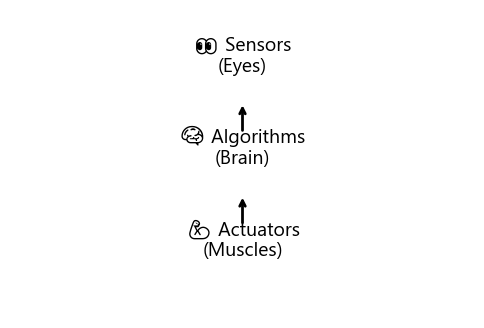

In [2]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'Segoe UI Emoji'

fig, ax = plt.subplots(figsize=(6,4))
ax.axis('off')
ax.text(0.5, 0.8, "👀 Sensors\n(Eyes)", ha='center', fontsize=14)
ax.text(0.5, 0.5, "🧠 Algorithms\n(Brain)", ha='center', fontsize=14)
ax.text(0.5, 0.2, "💪 Actuators\n(Muscles)", ha='center', fontsize=14)
ax.annotate("", xy=(0.5,0.7), xytext=(0.5,0.6), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.5,0.4), xytext=(0.5,0.3), arrowprops=dict(arrowstyle="->", lw=2))
plt.show()



## 2. System Architecture

ADAS pipeline: **Perception → Planning → Control → Actuation**



### (a) Perception – "Seeing the World"
**Sensors:**
- Cameras → detect lanes, signs, pedestrians
- Radar → works in poor weather, measures speed & distance
- LiDAR → 3D mapping
- IMU + GNSS → position & orientation

**Algorithms:**
- Sensor Fusion (e.g., Kalman Filter)
- Object Detection (CNNs, YOLO)

**Output:** Environment model + vehicle state


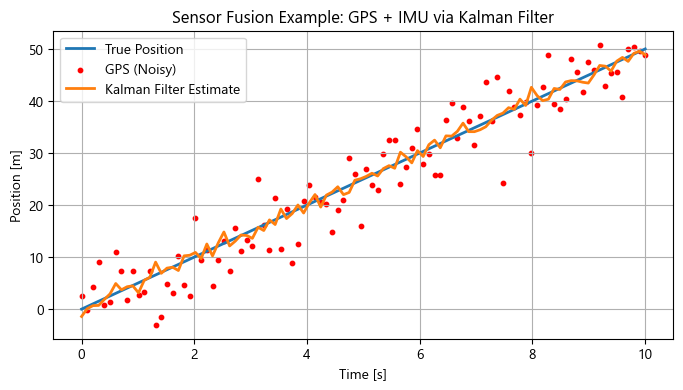

In [3]:

# Sensor fusion visualization: GPS vs Kalman estimate
import numpy as np

np.random.seed(42)
t = np.linspace(0,10,100)
true_pos = 5*t
gps_noise = np.random.normal(0, 5, size=t.shape)
gps_measurements = true_pos + gps_noise
kf_estimate = true_pos + np.random.normal(0,1,size=t.shape)

plt.figure(figsize=(8,4))
plt.plot(t, true_pos, label="True Position", lw=2)
plt.scatter(t, gps_measurements, label="GPS (Noisy)", color='red', s=10)
plt.plot(t, kf_estimate, label="Kalman Filter Estimate", lw=2)
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.title("Sensor Fusion Example: GPS + IMU via Kalman Filter")
plt.legend()
plt.grid(True)
plt.show()



### (b) Planning – "Deciding What to Do"
- **Path Planning:** Geometric path.
- **Motion Planning:** Adds timing and dynamics.

*Example:* Adaptive Cruise Control maintains safe following distance.

### (c) Control – "Executing the Plan"
- **Longitudinal Control:** Throttle & brake for speed.
- **Lateral Control:** Steering for lane keeping.
- **Objectives:** Stability, Accuracy, Robustness



## 3. Mathematical Foundations

### (a) Kinematic Bicycle Model
Used at low/moderate speeds.


c:\Users\zeelp\anaconda3\envs\carla-sim\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 948 (\N{GREEK SMALL LETTER DELTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


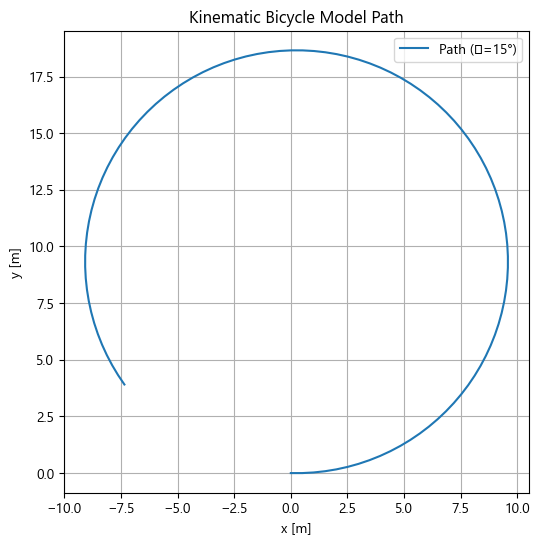

In [4]:

# Kinematic model simulation: vehicle path with steering
L = 2.5  # wheelbase
delta = np.deg2rad(15)  # steering angle
v = 10
t = np.linspace(0,5,100)
x, y, theta = [0], [0], [0]

for i in range(1,len(t)):
    dt = t[i]-t[i-1]
    x_dot = v*np.cos(theta[-1])
    y_dot = v*np.sin(theta[-1])
    theta_dot = v/L*np.tan(delta)
    x.append(x[-1]+x_dot*dt)
    y.append(y[-1]+y_dot*dt)
    theta.append(theta[-1]+theta_dot*dt)

plt.figure(figsize=(6,6))
plt.plot(x, y, label=f"Path (δ={np.rad2deg(delta):.0f}°)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Kinematic Bicycle Model Path")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()



### (b) Dynamic Bicycle Model

The **dynamic model** includes tire forces and yaw dynamics.

**Equations:**
- Lateral: $m(\dot{v}_y + r v_x) = F_{yf} + F_{yr}$  
- Longitudinal: $m(\dot{v}_x - r v_y) = F_{xf} + F_{xr} - F_{drag} - F_{roll}$  
- Yaw: $I_z \dot{r} = L_f F_{yf} - L_r F_{yr}$  

**Slip Angles:**  
- $F_y = -C_\alpha \cdot \alpha$  
- $\alpha$ = slip angle

Explains **understeer** and **oversteer** behavior.


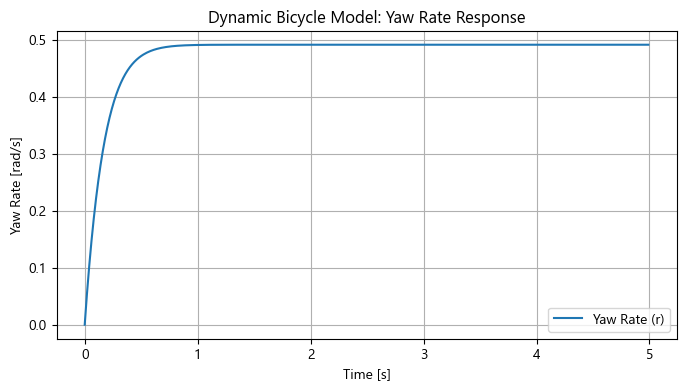

In [5]:

# Dynamic model simulation: yaw rate response to steering input
m = 1500      # kg
Iz = 3000     # yaw inertia (kg m^2)
Lf, Lr = 1.2, 1.3
Cf, Cr = 80000, 80000
vx = 15       # m/s

dt = 0.01
t = np.arange(0,5,dt)
r, vy = [0], [0]
delta = np.deg2rad(5)

for i in range(1,len(t)):
    vy_k, r_k = vy[-1], r[-1]
    alpha_f = np.arctan((vy_k + Lf*r_k)/vx) - delta
    alpha_r = np.arctan((vy_k - Lr*r_k)/vx)
    Fyf = -Cf*alpha_f
    Fyr = -Cr*alpha_r
    vy_dot = (Fyf+Fyr)/m - r_k*vx
    r_dot = (Lf*Fyf - Lr*Fyr)/Iz
    vy.append(vy_k+vy_dot*dt)
    r.append(r_k+r_dot*dt)

plt.figure(figsize=(8,4))
plt.plot(t, r, label="Yaw Rate (r)")
plt.xlabel("Time [s]")
plt.ylabel("Yaw Rate [rad/s]")
plt.title("Dynamic Bicycle Model: Yaw Rate Response")
plt.grid(True)
plt.legend()
plt.show()



## 4. Control Strategies

### Traditional Control
- **PID Control:** P → present error, I → accumulated error, D → predicted error.
- **MPC (Model Predictive Control):** Predicts future states with constraints.

### Learning-Based Control
- **Imitation Learning:** Learns from human drivers, risk of poor generalization.
- **Reinforcement Learning:** Learns via rewards, e.g., PPO for lane keeping.


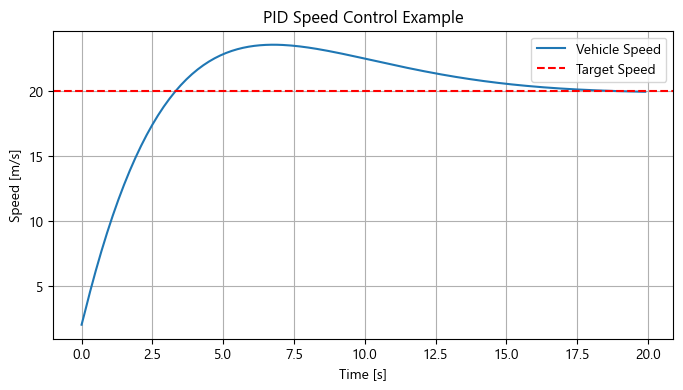

In [6]:

# PID control simulation for speed
target_speed = 20
dt = 0.1
time = np.arange(0,20,dt)
Kp, Ki, Kd = 0.5, 0.1, 0.05

v = 0
integral = 0
prev_error = 0
speeds = []

for t in time:
    error = target_speed - v
    integral += error*dt
    derivative = (error - prev_error)/dt
    throttle = Kp*error + Ki*integral + Kd*derivative
    v += throttle*dt
    prev_error = error
    speeds.append(v)

plt.figure(figsize=(8,4))
plt.plot(time, speeds, label="Vehicle Speed")
plt.axhline(target_speed, color='r', linestyle='--', label="Target Speed")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.title("PID Speed Control Example")
plt.legend()
plt.grid(True)
plt.show()



## 5. Sideslip Angle (β)

**Definition:** Angle between heading and actual velocity direction.

**Formula:** $\beta = \arctan(\frac{v_y}{v_x})$

**Importance:** Key for stability and ESC.


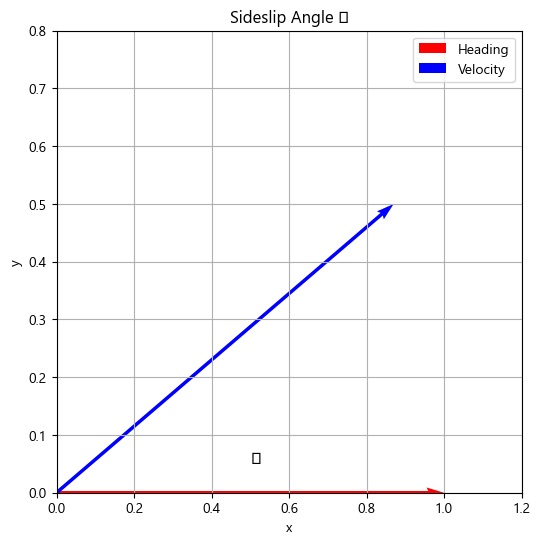

In [8]:

# Visualize sideslip angle β
plt.figure(figsize=(6,6))
plt.quiver(0,0,1,0,angles='xy',scale_units='xy',scale=1,color='r',label="Heading")
plt.quiver(0,0,0.87,0.5,angles='xy',scale_units='xy',scale=1,color='b',label="Velocity")
plt.text(0.5,0.05,"β",fontsize=12)
plt.xlim(0,1.2)
plt.ylim(0,0.8)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sideslip Angle β")
plt.legend()
plt.grid(True)
plt.show()



## 6. Collaborative ADAS → CAVs

Enabled by **V2X Communication**.

**Applications:**
- Platooning → fuel saving, safety.
- Cooperative Merging → smooth on-ramps.
- Intersection Management → slot-based crossing.
- Eco-routing → energy-efficient driving.



## 7. Challenges in ADAS

- **Real-Time Computation**
- **Robustness in Adverse Conditions**
- **Interpretability of AI**
- **Human Trust and Takeover**
- **Edge Case Testing**



## 8. SAE Automation Levels

- **Level 0:** No Automation
- **Level 1:** Assistance (Cruise Control)
- **Level 2:** Partial Automation (Lane Keeping + ACC)
- **Level 3:** Conditional Automation
- **Level 4:** High Automation (limited domains)
- **Level 5:** Full Automation



## ✅ Summary

ADAS integrates **Perception → Planning → Control → Actuation**.

Dynamic modeling, robust control strategies, and collaborative communication form the foundation for future autonomous vehicles.
